In [1]:
import pandas as pd
import gensim
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
from pprint import pprint

import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
import numpy as np
import tqdm

In [2]:
data = pd.read_csv('scrape/restaurant-data/cleaned_restaurant_reviews.csv', index_col=0)

In [3]:
data = data.reset_index(drop=True)

In [4]:
data

,url,name,neighbourhood,price,categories,review,user,date,cleaned_price,cleaned_categories,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
1,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
2,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nPeanut sauce was ace\nI love a good satay pe...,Ally Tan,Jul 30 at 4:10pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
3,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nClassic BBQ wings\nJuicy and tasty like it’s...,Ally Tan,Jul 30 at 4:09pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
4,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nBBQ stingray\nIt was yummy but slight warnin...,Ally Tan,Jul 30 at 4:08pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28294,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\nBento Box D $13.80\n川椒雞柳 | 鮮腐竹蝦球 | 清炒西蘭花 | ...,K T,"Oct 27, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central
28295,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\nBento Box C $11.80\n普寧豆醬走地雞 | 鮮菌翡翠豆腐 | 蒜茸炒四...,K T,"Oct 26, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central
28296,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\nBento Box B $11.80\n蒜子豆豉凉瓜黑豬梅肉 | 香菌扒豆腐 | 蒜茸...,K T,"Oct 9, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central
28297,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\n潮州糜 Bento A $12.80\n鹵鴨拼豆干 | 川椒雞 | 欖菜四季苗| 菜脯...,K T,"Oct 1, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central


## New Cleaning

In [8]:
import emoji
import regex as re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

ps = PorterStemmer()

In [6]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"o\'clock", "clock", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"that\'s", "that is", phrase)       
    phrase = re.sub(r"go-around", "go around", phrase)  
    # general
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    #phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['address', 'note', 'tel', 'website', 'open', 'burpple']
add_stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
    'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
    's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
    'won', "won't", 'wouldn', "wouldn't"])
add_stopwords_2 =  ['n','s','m','i','1','2','3','4','5','6','7','8','9','10','one','two',
    'it','in','ve','well','could','would','really','also','even',
    'alway','always','still','never','much','thing','yet',
    'said','asked','did','go','got','do','make','know','think','come','going',
    'put','went','seem','order','ordered','give','eat','make','get']

stopwords.extend(new_stopwords)
stopwords.extend(add_stopwords)
stopwords.extend(add_stopwords_2)

In [10]:
cleaned_review_list = []
count = 0

for review in data['review']:
    # lower case
    review = review.lower()

    # deemojize
    review = emoji.demojize(review)

    # remove headers
    review = ' '.join(review.split('\n')[2:])

    # remove location (pushpin or location:)
    review = review.split('round_pushpin')[0]
    review = review.split('location:')[0]

    # clean punctuation
    review = re.sub(r'[^\w\s]', '', review)

    # tokenize
    tokens = word_tokenize(review)

    # remove stopwords and URLs
    tokens = [word for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if 'http' not in word]
    tokens = [word for word in tokens if 'www' not in word]

    # decontraction
    tokens = [decontracted(word) for word in tokens]

    ### to add in translation code... shld translate each token

    ### never do stemming (i see online ppl do doc2vec like nv do stemming.....)

    # concatenate tokens back
    cleaned_review = " ".join(tokens)
    cleaned_review_list.append(cleaned_review)

    if count%1000 == 0:
        print(count)
    count+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [11]:
# replace the old cleaned text
data['cleaned_text'] = cleaned_review_list

In [12]:
restaurant_review_df = data[['url', 'cleaned_text']]
restaurant_review_df = restaurant_review_df.groupby(['url'], as_index = False).agg({'cleaned_text': ' '.join})

In [13]:
restaurant_review_df

,url,cleaned_text
0,https://www.burpple.com/108-matcha-saro?bp_ref...,s850 strong matcha flavor soft serve topped wh...
1,https://www.burpple.com/136-hong-kong-street-f...,zhi char feast family loves tze char lost coun...
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,four hand dinner chef alvin chef jay legendary...
3,https://www.burpple.com/25-degrees-singapore?b...,oh yesh loveeeee burgers goooooood located hot...
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,signature firebird koreaninspired sandwich fri...
...,...,...
840,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2...,stir fried yunnan rice noodles assorted seafoo...
841,https://www.burpple.com/zafferano?bp_ref=%2Ff%...,portion spaghetti dressed tomato extraction ol...
842,https://www.burpple.com/zai-shun-curry-fish-he...,favourite cold weather food hearty comforting ...
843,https://www.burpple.com/zazz-pizza?bp_ref=%2Ff...,beside pizza tried braised veel cheek papparde...


## LDA

In [14]:
# create dictionary
docs = data['cleaned_text'] ###
processed_docs = [d.split() for d in docs]
dictionary = gensim.corpora.Dictionary(processed_docs)

In [15]:
# term document frequency
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [16]:
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=10,
                                       alpha=0.1, # document topic density. higher alpha, documents composed of more topics
                                       eta=0.01, # topic word density. higher beta, topics composed of large number of words in the corpus
                                       chunksize=100, # number of documents to consider at once
                                       passes=10, # number of times to go through the entire corpus
                                       random_state =100)

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.020*"noodles" + 0.017*"soup" + 0.017*"pork" + 0.017*"fish" + '
  '0.015*"sauce" + 0.015*"flavour" + 0.014*"fried" + 0.013*"sweet" + '
  '0.012*"prawn" + 0.012*"broth"'),
 (1,
  '0.014*"available" + 0.013*"duck" + 0.011*"delivery" + 0.008*"set" + '
  '0.007*"year" + 0.007*"black" + 0.007*"new" + 0.006*"sauce" + 0.006*"enjoy" '
  '+ 0.006*"per"'),
 (2,
  '0.028*"cream" + 0.022*"sweet" + 0.018*"chocolate" + 0.013*"ice" + '
  '0.010*"cake" + 0.009*"coconut" + 0.009*"dessert" + 0.008*"tart" + '
  '0.007*"soft" + 0.007*"croissant"'),
 (3,
  '0.026*"tea" + 0.022*"coffee" + 0.018*"matcha" + 0.015*"sweet" + '
  '0.015*"taste" + 0.014*"milk" + 0.013*"drink" + 0.012*"like" + 0.011*"good" '
  '+ 0.009*"flavour"'),
 (4,
  '0.023*"cheese" + 0.014*"fries" + 0.014*"beef" + 0.013*"burger" + '
  '0.012*"good" + 0.011*"sauce" + 0.010*"crispy" + 0.009*"juicy" + '
  '0.009*"meat" + 0.007*"tender"'),
 (5,
  '0.020*"salmon" + 0.017*"food" + 0.014*"great" + 0.013*"beef" + '
  '0.012*"place" + 0.012*

In [18]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
lda_score = coherence_model_lda.get_coherence()
lda_score

0.5077218688882521

In [19]:
def compute_coherence_values(k):
    
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           alpha=0.1, # document topic density. higher alpha, documents composed of more topics
                                           eta=0.01, # topic word density. higher beta, topics composed of large number of words in the corpus
                                           chunksize=100, # number of documents to consider at once
                                           passes=10, # number of times to go through the entire corpus
                                           random_state =100)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [20]:
# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')


# model_results = {
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)))
    
#     # iterate through number of topics
#     for k in topics_range:
#         # iterate through alpha values
#         for a in alpha:
#             # iterare through beta values
#             for b in beta:
#                 # get the coherence score for the given parameters
#                 cv = compute_coherence_values(k=k, a=a, b=b)
#                 # Save the model results
#                 model_results['Topics'].append(k)
#                 model_results['Alpha'].append(a)
#                 model_results['Beta'].append(b)
#                 model_results['Coherence'].append(cv)
                
#                 pbar.update(1)
#     pd.DataFrame(model_results).to_csv('restaurant_lda_tuning_results.csv', index=False)
#     pbar.close()

In [21]:
# iterate through number of topics
coherence_values = []
topics_range = range(2,11,1)

for k in topics_range:
    value = compute_coherence_values(k)
    print(k)
    print(value)
    coherence_values.append(value)

2
0.4650823074004923
3
0.4996107035236113
4
0.4852814839313129
5
0.48687367573866364
6
0.5055867115695353
7
0.49032740557695226
8
0.5208583403264051
9
0.49352128209411333
10
0.5158578031518308


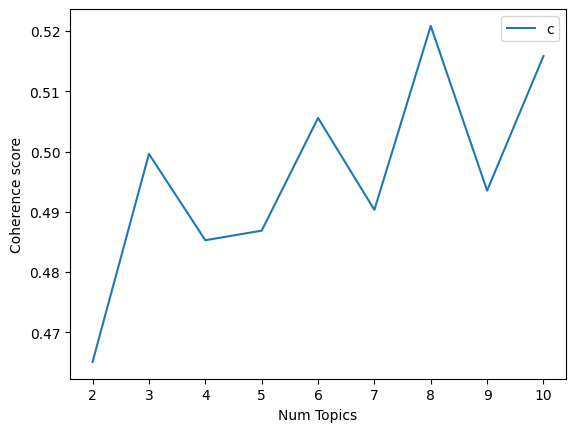

In [22]:
# Show graph
plt.plot(topics_range, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# choose num topics == 6 instead since 6 & 7 is stable.

In [29]:
# optimal parameters
num_topics = 6 ### CHANGE THIS

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                        id2word=dictionary,
                                        num_topics=num_topics,
                                        alpha=0.1, # document topic density. higher alpha, documents composed of more topics
                                        eta=0.01, # topic word density. higher beta, topics composed of large number of words in the corpus
                                        chunksize=100, # number of documents to consider at once
                                        passes=10, # number of times to go through the entire corpus
                                        random_state =100)
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.020*"pork" + 0.018*"rice" + 0.016*"fried" + 0.016*"chicken" + '
  '0.016*"soup" + 0.015*"sauce" + 0.013*"noodles" + 0.012*"fish" + 0.009*"egg" '
  '+ 0.009*"prawn"'),
 (1,
  '0.019*"good" + 0.013*"like" + 0.009*"quite" + 0.009*"pretty" + '
  '0.009*"taste" + 0.006*"time" + 0.006*"try" + 0.006*"though" + 0.006*"dont" '
  '+ 0.006*"food"'),
 (2,
  '0.022*"sweet" + 0.021*"cream" + 0.012*"chocolate" + 0.010*"cake" + '
  '0.009*"flavour" + 0.009*"soft" + 0.008*"butter" + 0.007*"cheese" + '
  '0.007*"coconut" + 0.007*"bread"'),
 (3,
  '0.015*"tea" + 0.013*"coffee" + 0.011*"matcha" + 0.010*"taste" + '
  '0.009*"drink" + 0.009*"milk" + 0.008*"good" + 0.008*"like" + 0.008*"try" + '
  '0.007*"ice"'),
 (4,
  '0.014*"cheese" + 0.013*"good" + 0.011*"sauce" + 0.010*"pasta" + '
  '0.010*"beef" + 0.009*"fries" + 0.009*"dish" + 0.009*"food" + '
  '0.009*"truffle" + 0.008*"burger"'),
 (5,
  '0.016*"menu" + 0.011*"set" + 0.009*"dishes" + 0.009*"restaurant" + '
  '0.009*"served" + 0.008*"availab

In [30]:
# Visualize the topics 
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('restaurant_ldavis_prepared_'+str(num_topics)+'_new_cleaning')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'restaurant_ldavis_prepared_'+ str(num_topics) +'_new_cleaning.html')
LDAvis_prepared

### https://we1s.ucsb.edu/research/we1s-tools-and-software/topic-model-observatory/tmo-guide/tmo-guide-pyldavis/
# A “relevance metric” slider scale at the top of the right panel controls how the words for a topic are sorted.
# lambda 1: sorts words by their frequency in the topic (red bars)
# lambda 0: sorts words by their "lift". Words whose red bars are nearly as long as their blue bars will be at the top Lift means how much a word's frequency sticks out in a topic above the baseline of its overall frequency in the model

/Users/natalie/opt/anaconda3/envs/bt4221/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.081541  0.164258       1        1  20.974333
0      0.084654 -0.040732       2        1  18.920637
4     -0.004513  0.089632       3        1  18.095389
2     -0.128572 -0.230812       4        1  14.980581
3     -0.132162  0.043260       5        1  14.215779
5      0.262134 -0.025606       6        1  12.813280, topic_info=           Term         Freq        Total Category  logprob  loglift
179        pork  5581.000000  5581.000000  Default  30.0000  30.0000
853       cream  4628.000000  4628.000000  Default  29.0000  29.0000
73         soup  3455.000000  3455.000000  Default  28.0000  28.0000
692        rice  5105.000000  5105.000000  Default  27.0000  27.0000
53        fried  4030.000000  4030.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
692        rice   805.951706  5105.649178   Topic6  -5.1695   0.2086
3417    premium   445.457562   742.840791   Topic6  -5.7624   1.5433
17        sauce   644.481648  7120.301334   Topic6  -5.3931  -0.3476
886   signature   496.693184  1459.688413   Topic6  -5.6535   0.9767
308       visit   473.670461  1266.157377   Topic6  -5.7010   1.0715

[537 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1206      2  1.003664  1290
1069      1  0.006055    14
1069      2  0.004541    14
1069      3  0.709907    14
1069      4  0.108984    14
...     ...       ...   ...
3650      4  0.008022  year
3650      5  0.058163  year
3650      6  0.828322  year
3757      6  1.001141    yu
8279      3  0.997535    zi

[1340 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 4, 6])